In [1]:
# Import all dependencies
from pandas import Series

import pandas as pd

# For text cleaning
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import nltk
import string
import re

# For text analysis
from nltk.collocations import *
from nltk.text import Text 

import itertools
import collections

# For text classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import numpy as np

# For sentimental analysis
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
from gensim.models import Word2Vec
from time import time  # To time our operations

import multiprocessing

# For visualization
from matplotlib.ticker import MaxNLocator
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_excel('data/Social_Dataset.xlsx', sheet_name='Raw Data')
df.head(5)

,Post ID,Post Date,Title,Content,Post Type,URL,Channel Name,Channel Country,Channel Site Type,Channel Language,Channel URL,Voice Name,Voice URL
0,17918370680,2019-04-30 21:50:01,@debbstarr @heysayfey We didn’t juice the thug...,@debbstarr @heysayfey We didn’t juice the thug...,COMMENT,https://twitter.com/mrbrown/statuses/112322297...,Twitter - Singapore,SG,MICROBLOG,en_US,http://twitter.com/?Singapore,mrbrown,https://twitter.com/mrbrown
1,17089508072,2018-12-17 20:45:20,FRUIT JUICES by @nutricallyfit . Are fruit jui...,FRUIT JUICES by @nutricallyfit . Are fruit jui...,COMMENT,https://twitter.com/NutricallyFit/statuses/107...,Twitter - Singapore,SG,MICROBLOG,en_US,http://twitter.com/?Singapore,NutricallyFit,https://twitter.com/NutricallyFit
2,17060776758,2018-12-13 10:36:00,are all the juices taste the same?,reds79 wrote: juices are sweet that not the ri...,COMMENT,http://forums.hardwarezone.com.sg/eat-drink-ma...,HardwareZone Forum - Eat-Drink-Man-Woman,SG,FORUM,en_US,http://forums.hardwarezone.com.sg/eat-drink-ma...,Qwerrty2000,http://forums.hardwarezone.com.sg/users/79493/
3,17063501377,2018-12-13 10:36:00,are all the juices taste the same?,reds79 wrote: juices are sweet that not the ...,COMMENT,http://forums.hardwarezone.com.sg/eat-drink-ma...,HardwareZone Forum - Eat-Drink-Man-Woman,SG,FORUM,en_US,http://forums.hardwarezone.com.sg/eat-drink-ma...,Qwerrty2000,http://forums.hardwarezone.com.sg/users/79493/
4,20031168942,2019-04-26 13:00:01,These places are JUICE perfect! HIC JUICE A J...,These places are JUICE perfect! HIC JUICE A J...,ARTICLE,http://www.facebook.com/permalink.php?story_fb...,The Finder Singapore Facebook Page,SG,SOCIAL_NETWORKING_SITE,en_US,http://www.facebook.com/136700966349096?sk=wall,The Finder Singapore,http://www.facebook.com/136700966349096


In [3]:
df.columns

Index(['Post ID', 'Post Date', 'Title', 'Content', 'Post Type', 'URL',
       'Channel Name', 'Channel Country', 'Channel Site Type',
       'Channel Language', 'Channel URL', 'Voice Name', 'Voice URL'],
      dtype='object')

In [4]:
df['Channel Language'].unique()

array(['en_US', 'en_GB', 'ms_MY', 'zh_CN', 'zh_TW'], dtype=object)

In [5]:
df.groupby('Channel Language').count()['Post ID']

Channel Language
en_GB     271
en_US    7778
ms_MY       7
zh_CN      15
zh_TW       1
Name: Post ID, dtype: int64

In [6]:
df.groupby('Post Type').count()['Post ID']

Post Type
ARTICLE     594
COMMENT    7478
Name: Post ID, dtype: int64

In [7]:
df.groupby('Channel Name').count()['Post ID']

Channel Name
112 Katong Facebook Page              1
313@Somerset Facebook Page            1
7-Eleven Singapore Facebook Page      5
8频道新闻新加坡 Channel 8 news - Facebook    2
938Live-Official Facebook page        1
                                     ..
mrbrown Facebook Page                 3
orchardgateway Facebook Page          1
theonlinecitizen Facebook Page        9
华新 Forum - 华新鲜事                       1
华新 forum - 非常代购                       2
Name: Post ID, Length: 351, dtype: int64

In [8]:
df.shape

(8072, 13)

In [9]:
# df.to_csv('data/raw_data.csv')

In [10]:
# Text cleaning
stop_words = set(stopwords.words('english'))

def remove_(txt):
    "remove hashtag, @user, link of a post using regular expression"
    return ' '.join(
        re.sub(
            "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", txt
        ).split())

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_cleaner(text):
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # filter out word searched, e.g. juice and beverage
    addntl_stopwords = ['juices', 'beverages', 'juice', 'beverage']
    words = [w for w in words if not w in addntl_stopwords]
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    #filter out one-letter words
    words = [w for w in lemmatized if len(w) > 1]
    return ' '.join(words)

df['cleaned_content'] = df['Content'].apply(remove_)
df['cleaned_content'] = df['cleaned_content'].apply(text_cleaner)

list_duplicates = [1 if x else 0 for x in df.duplicated(subset='cleaned_content', keep='first')]
df['duplicates'] = list_duplicates

print("Number of duplicated posts:", df['duplicates'].sum())
df['cleaned_content'][:5]

Number of duplicated posts: 2622


0                           thug life thug life juiced
1    fruit fruit really healthy claim fresh fruit e...
2                         write sweet right type meant
3                         write sweet right type meant
4    place perfect hic juicery ega clinic anti dote...
Name: cleaned_content, dtype: object

In [11]:
# df.to_csv('data/cleaned.csv', index=False)

## Word count

In [12]:
df = df[df['duplicates']==0].reset_index(drop=True)

In [13]:
# Create a list of lists containing words per post
words_per_post = [word.split() for word in df['cleaned_content']]

# List of all words across posts
all_words = list(itertools.chain(*words_per_post))

# Create counter
counts_ = collections.Counter(all_words)

df_clean = pd.DataFrame(counts_.most_common(), columns=['words', 'count'])
df_clean.head()

,words,count
0,say,1182
1,get,1173
2,like,1149
3,write,1145
4,drink,1085


In [14]:
# df_clean.to_csv('data/word_count.csv')

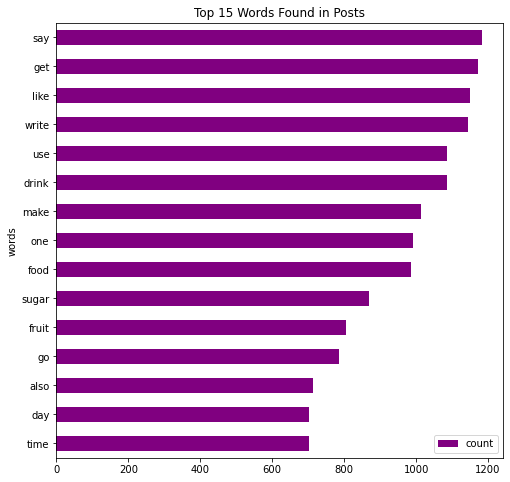

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_clean.sort_values(by='count', ascending=False).head(15).sort_values(
    by='count').plot.barh(x='words', y='count', ax=ax, color="purple")

ax.set_title("Top 15 Words Found in Posts")

plt.show();

## Collocation

In [16]:
df_words = pd.concat(
    [Series(
        row['Post ID'], row['cleaned_content'].split(' ')
    ) for _, row in df.iterrows()
    ]
).reset_index()
df_words.head()

,index,0
0,thug,17918370680
1,life,17918370680
2,thug,17918370680
3,life,17918370680
4,juiced,17918370680


In [17]:
# df_words.to_csv('data/word_list.csv', index=False)

In [18]:
def pairwise(t):
    x = t[:-1]
    y = t[1:]
    return zip(x, y)

def triwise(t):
    x = t[:-2]
    y = t[1:-1]
    z = t[2:]
    return zip(x, y, z)

# df.cleaned_content.apply(lambda x: pairwise(x.split(' ')))
df.cleaned_content.apply(lambda x: x.split(' '))

0                        [thug, life, thug, life, juiced]
1       [fruit, fruit, really, healthy, claim, fresh, ...
2                      [write, sweet, right, type, meant]
3       [place, perfect, hic, juicery, ega, clinic, an...
4       [sumit, nanda, founder, ega, clinic, tell, col...
                              ...                        
5445    [store, clerk, vape, store, fire, friday, even...
5446    [kate, spade, write, ooh, trotter, look, yum, ...
5447    [currently, wear, start, year, ago, idental, s...
5448    [ghost, town, vacant, unit, protest, china, pr...
5449    [dr, zoe, harcombe, phd, many, thanks, fabulou...
Name: cleaned_content, Length: 5450, dtype: object

In [19]:
print(tuple(df.cleaned_content.apply(lambda x: triwise(x.split(' ')))[0]))

(('thug', 'life', 'thug'), ('life', 'thug', 'life'), ('thug', 'life', 'juiced'))


In [20]:
df_bigrams = pd.concat(
    [Series(
        row['Post ID'], pairwise(row['cleaned_content'].split(' '))
    ) for _, row in df.iterrows()
    ]
).reset_index()
df_bigrams['bigrams'] = df_bigrams['index'].apply(lambda x: remove_(str(x)))
df_bigrams.drop('index', axis=1, inplace=True)
df_bigrams.head()

,0,bigrams
0,17918370680,thug life
1,17918370680,life thug
2,17918370680,thug life
3,17918370680,life juiced
4,17089508072,fruit fruit


In [21]:
# df_bigrams.to_csv('data/bigrams.csv', index=False)

In [22]:
df_trigrams = pd.concat(
    [Series(
        row['Post ID'], triwise(row['cleaned_content'].split(' '))
    ) for _, row in df.iterrows()
    ]
).reset_index()
df_trigrams['trigrams'] = df_trigrams['index'].apply(lambda x: remove_(str(x)))
df_trigrams.drop('index', axis=1, inplace=True)
df_trigrams.head()

,0,trigrams
0,17918370680,thug life thug
1,17918370680,life thug life
2,17918370680,thug life juiced
3,17089508072,fruit fruit really
4,17089508072,fruit really healthy


In [23]:
# df_trigrams.to_csv('data/trigrams.csv', index=False)

In [24]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words)
finder.apply_freq_filter(3)
finder.nbest(bigram_measures.pmi, 10)  # doctest: +NORMALIZE_WHITESPACE

[('akin', 'chikong'),
 ('asthmatic', 'copd'),
 ('avry', 'vlv'),
 ('bernice', 'punny'),
 ('bhutan', 'rambutan'),
 ('dalia', 'itzik'),
 ('fetchrss', 'hbnaturals'),
 ('flor', 'lughing'),
 ('genetic', 'disposition'),
 ('goodhealth', 'naturalsupplement')]

In [25]:
finder2 = TrigramCollocationFinder.from_words(all_words)
finder2.apply_freq_filter(3)
finder2.nbest(trigram_measures.pmi, 10)  # doctest: +NORMALIZE_WHITESPACE

[('halalgoodsdogood', 'standrewsseniorcare', 'lionsbefrienders'),
 ('nil', 'sine', 'labore'),
 ('sinusitis', 'asthmatic', 'copd'),
 ('dalia', 'itzik', 'chairman'),
 ('sine', 'labore', 'problemo'),
 ('sata', 'andagi', 'okinawan'),
 ('yacht', 'rv', 'camper'),
 ('itzik', 'chairman', 'parliamentary'),
 ('asthmatic', 'copd', 'sufferer'),
 ('avry', 'vlv', 'zouk')]

## Concordance

In [26]:
Text(all_words).concordance('say', 100, 10)

Displaying 10 of 1182 matches:
hang get juiced singapore sweet best boring one say one ever funky fresh flavour new bar town wide 
ruit tree fresh singapore less sugar honest bad say well know love sugar lah tend respond well less
amage thought fresh fruit nutritious would harm say scmp zhuang pinghui publish mar woman central c
it nutritious would harm inject body zeng quote say idea would get trouble liu warn health practice
 liu warn health practice lack scientific basis say inject vein could cause liver kidney damage eve
t social medium lu zhongyi nutritionist beijing say weibo china equivalent twitter fruit good vein 
range fruit eugenenitic singapore use apple ppl say drink alcohol co look like white wine sent imag
n refund salary satkisasuke write use apple ppl say drink alcohol co look like white wine sent imag
unrequited puppy love still linger others heart say goodbye rt miyazaki yuka join treat yanamin lik
acket fruit unhealthy mainly alot sugar include say less sweet less s

## Text Classification (Unsupervised)

In [27]:
def vectorize(words):
    """Returns a vectorized bag of words and the list of nonzero features"""
    tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   token_pattern=r'[a-z-]+')
    bow = tfidf_vectorizer.fit_transform(words)
    nonzeros = bow.sum(axis=1).nonzero()[0]
    bow = bow[nonzeros]
    return bow, nonzeros

def cluster_range(X, clusterer, k_start, k_stop):
    """Get the range of clusters per internal validation"""
    scs = []
    inertias = []
    
    for i in range(k_start, k_stop+1):

        new_clusterer = clusterer
        new_clusterer.n_clusters = i
        
        y = new_clusterer.fit_predict(X)

        scs.append(silhouette_score(X, y))     
        inertias.append(new_clusterer.inertia_)
        
    ret = {'scs':scs,
     'inertias':inertias
    }
    return ret

def plot_internal(inertias, scs):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return ax

def df_clustered(df, nonzeros, clusters):
    """Returns a DataFrame of titles with cluster number"""
    clustered_table = df.iloc[list(nonzeros)]
    clustered_table['Cluster'] = clusters
    clustered_table = clustered_table.reset_index(drop=True)
    return clustered_table

def visualize(df, n):
    """Returns a wordcloud of titles for visualization"""
    clean_string_group = re.sub('\W', ' ', ' '.join(
        df.groupby('Cluster').get_group(n).cleaned_content))
    wordcloud = WordCloud(max_words=300, background_color='white', scale=3,
                          colormap='viridis').generate(clean_string_group)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [28]:
# Vectorize the lemmatized words
# Get only the nonzeros features in the vectorized bag of words
bow_X, nonzeros = vectorize(df.cleaned_content)

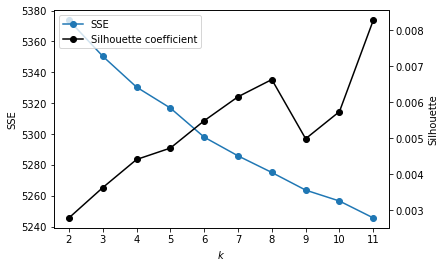

In [29]:
# Find clusters using internal validation
# Sum of squares distances to centroids
# Silhouette coefficient
res_posts = cluster_range(bow_X, KMeans(random_state=1337), 2, 11)
plot_internal(res_posts['inertias'], res_posts['scs'])

In [30]:
# Choose five as number of clusters
kmeans_X = KMeans(random_state=1337, n_clusters=6)
y_predict_X = kmeans_X.fit_predict(bow_X)

In [31]:
# create a new DataFrame containing titles with cluster number (from 0 to 5)
df_new = df_clustered(df, nonzeros, y_predict_X)

<ipython-input-27-4a1c611e4092>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_table['Cluster'] = clusters


In [32]:
# Number of titles per clusters
df_new.groupby(['Cluster']).count()['Post ID']

Cluster
0     344
1     196
2     334
3    4008
4     256
5     308
Name: Post ID, dtype: int64

Cluster 1 : Fruit Juices


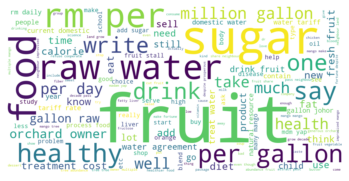

Cluster 2 : Shared Ideas about Juices


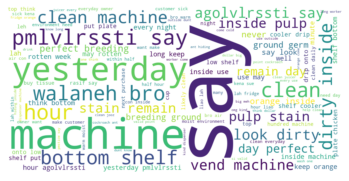

Cluster 3 : Drinking Juices


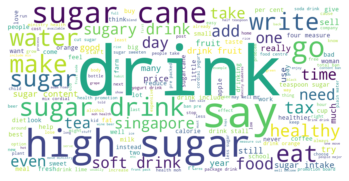

Cluster 4 : Making Juices


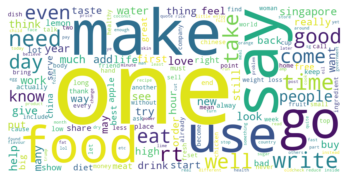

Cluster 5 : GAGT Users


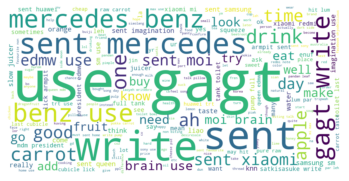

Cluster 6 : Orange Juices


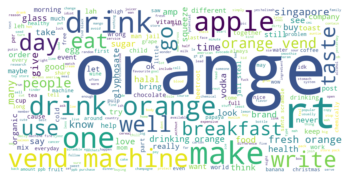

In [33]:
print("Cluster 1 : Fruit Juices")
visualize(df_new, 0)
print("Cluster 2 : Shared Ideas about Juices")
visualize(df_new, 1)
print("Cluster 3 : Drinking Juices")
visualize(df_new, 2)
print("Cluster 4 : Making Juices")
visualize(df_new, 3)
print("Cluster 5 : GAGT Users")
visualize(df_new, 4)
print("Cluster 6 : Orange Juices")
visualize(df_new, 5)

In [34]:
name_clusters = []
for i in range(df_new.shape[0]):
    if df_new['Cluster'].loc[i] == 0:
        name_clusters.append('Fruit Juice')
    elif df_new['Cluster'].loc[i] == 1:
        name_clusters.append('Machines Involving Juice')
    elif df_new['Cluster'].loc[i] == 2:
        name_clusters.append('Drinking Juice')
    elif df_new['Cluster'].loc[i] == 3:
        name_clusters.append('Making Juice')
    elif df_new['Cluster'].loc[i] == 4:
        name_clusters.append('GAGT Users')
    else:
        name_clusters.append('Orange Juice')
df_new['cluster_name'] = name_clusters

In [35]:
# df_new.to_csv('data/clustered.csv')

##  Sentimental Analysis (Unsupervised)

In [36]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.cleaned_content.split()))

def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [37]:
sent = [row.split() for row in df['cleaned_content']]

In [38]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [39]:
bigram = Phraser(phrases)

In [40]:
sentences = bigram[sent]

In [41]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

18882

In [42]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'write', 'get', 'like', 'drink', 'one', 'make', 'food', 'use', 'go']

In [43]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [44]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [45]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [46]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.55 mins


In [47]:
w2v_model.init_sims(replace=True)

In [48]:
w2v_model.wv.most_similar(positive=["say"])

[('never', 0.9143116474151611),
 ('saw', 0.9135363698005676),
 ('someone', 0.9119327068328857),
 ('told', 0.9100479483604431),
 ('tissue', 0.9090765714645386),
 ('yesterday', 0.9068223237991333),
 ('happen', 0.9059442281723022),
 ('self', 0.9053323268890381),
 ('ask', 0.9030165672302246),
 ('father', 0.9024893045425415)]

In [49]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=w2v_model.wv.vectors)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

In [50]:
# This cluster is negative since it contains negative words
w2v_model.wv.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('chill', 0.9925907850265503),
 ('watermelon', 0.9920538663864136),
 ('prepare', 0.9900248050689697),
 ('snack', 0.9899007081985474),
 ('favorite', 0.9889975786209106),
 ('frozen', 0.9861612319946289),
 ('grape', 0.9855084419250488),
 ('small', 0.9851926565170288),
 ('rock', 0.9850962162017822),
 ('desiresale', 0.9848517775535583)]

In [51]:
# This cluster is positive since it contains positive words
w2v_model.wv.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('female', 0.9941356182098389),
 ('reward', 0.9937229752540588),
 ('living', 0.9932645559310913),
 ('attention', 0.992156445980072),
 ('stupidity', 0.9898449778556824),
 ('extend', 0.9889816045761108),
 ('aim', 0.988099217414856),
 ('fail', 0.9876766204833984),
 ('friendly', 0.9869170188903809),
 ('correct', 0.9865424633026123)]

In [64]:
words = pd.DataFrame(w2v_model.wv.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: w2v_model.wv[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict(np.array(x).reshape(1, -1)))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==1 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [65]:
words.head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,life,"[0.064849235, 0.032064185, 0.05309434, 0.00520...",1,1,2.268461,2.268461
1,juiced,"[-0.051534373, 0.012428204, 0.019770663, -0.01...",0,-1,2.983644,-2.983644
2,fruit,"[-0.016749648, 0.086294025, -0.019490676, -0.0...",0,-1,1.501426,-1.501426
3,really,"[0.0501279, 0.039259207, 0.023785224, 0.002883...",1,1,2.572063,2.572063
4,healthy,"[0.015160204, 0.1137665, 0.02921592, -0.035791...",0,-1,1.488396,-1.488396


In [66]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(df['cleaned_content'])
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(df['cleaned_content'])

C:\ProgramData\Anaconda3\envs\new_base\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [67]:
replaced_tfidf_scores = df.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)

In [68]:
sentiment_dict = dict(zip(words.words.values, words.sentiment_coeff.values))
replaced_closeness_scores = df['cleaned_content'].apply(
    lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [69]:
replacement_df = pd.DataFrame(
    data=[replaced_closeness_scores, replaced_tfidf_scores, df['cleaned_content']]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)

In [70]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate
0,"[0, 2.26846065305097, 0, 2.26846065305097, -2....","[15.988232889260361, 9.582740003383726, 15.988...",thug life thug life juiced,27.934022
1,"[-1.501426383792803, -1.501426383792803, 2.572...","[9.805500316698666, 9.805500316698666, 4.24696...",fruit fruit really healthy claim fresh fruit e...,8.405216
2,"[1.4845922182748323, -3.3618054391907286, 3.19...","[2.8033842887620812, 4.743741952702608, 4.4795...",write sweet right type meant,39.260833
3,"[-2.952309143041174, -1.3612898916663092, 0, 0...","[4.791370001691863, 5.652310638482853, 8.21725...",place perfect hic juicery ega clinic anti dote...,-35.451123
4,"[0, 0, 0, 0, 0, 2.2301555465861984, -3.1201725...","[8.910407176504336, 8.910407176504336, 7.03860...",sumit nanda founder ega clinic tell cold press...,6.906046


In [71]:
replacement_df['sentimet'] = replacement_df['sentiment_rate'].apply(lambda x: "positive" if x > 0 else "negative" )

In [72]:
# replacement_df.to_csv('data/sentiments.csv', index=False)

In [73]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,sentimet
0,"[0, 2.26846065305097, 0, 2.26846065305097, -2....","[15.988232889260361, 9.582740003383726, 15.988...",thug life thug life juiced,27.934022,positive
1,"[-1.501426383792803, -1.501426383792803, 2.572...","[9.805500316698666, 9.805500316698666, 4.24696...",fruit fruit really healthy claim fresh fruit e...,8.405216,positive
2,"[1.4845922182748323, -3.3618054391907286, 3.19...","[2.8033842887620812, 4.743741952702608, 4.4795...",write sweet right type meant,39.260833,positive
3,"[-2.952309143041174, -1.3612898916663092, 0, 0...","[4.791370001691863, 5.652310638482853, 8.21725...",place perfect hic juicery ega clinic anti dote...,-35.451123,negative
4,"[0, 0, 0, 0, 0, 2.2301555465861984, -3.1201725...","[8.910407176504336, 8.910407176504336, 7.03860...",sumit nanda founder ega clinic tell cold press...,6.906046,positive


In [74]:
df[df['Post ID']==17405698882]['Post Date']

356   2019-02-16 10:50:32
Name: Post Date, dtype: datetime64[ns]

In [76]:
import datetime
df[df['Post ID']==17405698882]

,Post ID,Post Date,Title,Content,Post Type,URL,Channel Name,Channel Country,Channel Site Type,Channel Language,Channel URL,Voice Name,Voice URL,cleaned_content,duplicates
356,17405698882,2019-02-16 10:50:32,Bother. Guess I'll keep drinking orange juice....,Bother. Guess I'll keep drinking orange juice....,COMMENT,https://twitter.com/PaulFreelend/statuses/1096...,Twitter - Singapore,SG,MICROBLOG,en_US,http://twitter.com/?Singapore,PaulFreelend,https://twitter.com/PaulFreelend,bother guess keep drinking orange,0


In [77]:
df[df['Post ID']==17391537939]

,Post ID,Post Date,Title,Content,Post Type,URL,Channel Name,Channel Country,Channel Site Type,Channel Language,Channel URL,Voice Name,Voice URL,cleaned_content,duplicates
318,17391537939,2019-02-16 16:26:45,Bro ask everyone stay away from this orange ju...,Kesavan Dulce xiasuey orange juice,COMMENT,http://www.facebook.com/permalink.php?story_fb...,All Singapore Stuff Facebook Page,SG,SOCIAL_NETWORKING_SITE,en_US,http://www.facebook.com/1993145654159487?sk=wall,UserUnknown,http://www.facebook.com/UserUnknown,kesavan dulce xiasuey orange,0


In [78]:
df[df['Post ID']==17391537831]

,Post ID,Post Date,Title,Content,Post Type,URL,Channel Name,Channel Country,Channel Site Type,Channel Language,Channel URL,Voice Name,Voice URL,cleaned_content,duplicates
28,17391537831,2019-02-16 14:33:09,Bro ask everyone stay away from this orange ju...,Better to buy juices from fruit juice stall. Y...,COMMENT,http://www.facebook.com/permalink.php?story_fb...,All Singapore Stuff Facebook Page,SG,SOCIAL_NETWORKING_SITE,en_US,http://www.facebook.com/1993145654159487?sk=wall,UserUnknown,http://www.facebook.com/UserUnknown,well buy fruit stall know insect climb machine,0


In [79]:
df[df['Post ID']==17391122350]

,Post ID,Post Date,Title,Content,Post Type,URL,Channel Name,Channel Country,Channel Site Type,Channel Language,Channel URL,Voice Name,Voice URL,cleaned_content,duplicates
317,17391122350,2019-02-16 12:19:55,Bro ask everyone stay away from this orange ju...,I prefer the juice stall,COMMENT,http://www.facebook.com/permalink.php?story_fb...,All Singapore Stuff Facebook Page,SG,SOCIAL_NETWORKING_SITE,en_US,http://www.facebook.com/1993145654159487?sk=wall,UserUnknown,http://www.facebook.com/UserUnknown,prefer stall,0


In [84]:
print(df[df.cleaned_content=='mary tan'].URL)

3558    http://www.facebook.com/permalink.php?story_fb...
Name: URL, dtype: object
